# Отток клиентов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import chain
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder 

In [5]:
df_raw = pd.read_csv('/datasets/Churn.csv')
display(df_raw.head())
df_raw.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В датасете 10000 строк, есть пропуски в столбце "Tenure", удалим их. Помимо фамилии есть два нечисленных признака - географическое положение и пол. Порядки величин в столбцах отличаются - возраст, например, это несколько десятков, а примерная зарплата - десятки и сотни тысяч.

In [9]:
df_raw = df_raw.dropna()

Разделим таблицу на признаки и цель. Разделим данные на обучающую, валидационную и тестовую выборки и отмасшабируем численные признаки.

In [17]:
encoder = OrdinalEncoder() 
data_ordinal = pd.DataFrame(encoder.fit_transform(df_raw[['Geography', 'Gender']]), 
                                                      columns=df_raw[['Geography', 'Gender']].columns) 
data_ordinal

,Geography,Gender
0,0.0,0.0
1,2.0,0.0
2,0.0,0.0
3,0.0,0.0
4,2.0,0.0
...,...,...
9086,0.0,0.0
9087,0.0,1.0
9088,0.0,1.0
9089,0.0,0.0


In [22]:
features = df_raw.drop(['Surname', 'Exited'], axis=1)
target = df_raw['Exited']

#сначала разбиение на выборки
features_not_test, features_test, target_not_test, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target) #отделяем тестовую
features_train, features_valid, target_train, target_valid = train_test_split(
    features_not_test, target_not_test, test_size=0.25, random_state=12345, stratify=target_not_test) #отделяем валидационную

numeric = ['RowNumber', 'CustomerId', 'CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary']
#масштабирование численных
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train_num = pd.DataFrame(scaler.transform(features_train[numeric]), columns=features_train[numeric].columns)
features_valid_num = pd.DataFrame(scaler.transform(features_valid[numeric]), columns=features_valid[numeric].columns)
features_test_num = pd.DataFrame(scaler.transform(features_test[numeric]), columns=features_test[numeric].columns)

Посмотрим, сколько уникальных значений есть в столбцах 'Geography' и 'Gender', чтобы определиться с видом кодирования.

In [23]:
print(df_raw['Geography'].unique())
print(df_raw['Gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


Закодируем эти признаки с помощью OHE.

In [24]:
#кодирование категориальных
encoder = OrdinalEncoder() 

features_train_cat = features_train[['Geography', 'Gender']]
features_valid_cat = features_valid[['Geography', 'Gender']]
features_test_cat = features_test[['Geography', 'Gender']]

transformer = make_column_transformer((OneHotEncoder(drop='first'), ['Geography', 'Gender']), remainder='passthrough')

transformed = transformer.fit_transform(features_train_cat)
features_train_cat = pd.DataFrame(transformed, columns=transformer.get_feature_names())

transformed = transformer.transform(features_valid_cat)
features_valid_cat = pd.DataFrame(transformed, columns=transformer.get_feature_names())

transformed = transformer.transform(features_test_cat)
features_test_cat = pd.DataFrame(transformed, columns=transformer.get_feature_names())

display(features_test_cat.head())

,onehotencoder__x0_Germany,onehotencoder__x0_Spain,onehotencoder__x1_Male
0,1.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,1.0


Объединим обработанные численные и закодированные категориальные признаки.

In [25]:
features_train = pd.DataFrame.join(features_train_num, features_train_cat)
features_valid = pd.DataFrame.join(features_valid_num, features_valid_cat)
features_test = pd.DataFrame.join(features_test_num, features_test_cat)

display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)
display(target_train.shape)
display(target_valid.shape)
display(target_test.shape)

(5454, 13)

(1818, 13)

(1819, 13)

(5454,)

(1818,)

(1819,)

**Вывод по предобработке: пропуски удалены, нечисленные признаки были закодированы с помощью OHE, численные признаки были отмасштабированы. Данные разделены на обучающую, валидационную и тестовую выборки.**

## Исследование задачи

Стоящая перед нами задача - задача классификации, поэтому рассмотрим две модели, способные такие задачи решать: логистическую регрессию и случайный лес, то есть одну параметрическую и одну непараметрическую. Посмотрим на баланс классов.

In [26]:
target.value_counts(normalize=True)

0    0.796062
1    0.203938
Name: Exited, dtype: float64

Подберем параметры, обучим модели без учета дисбаланса классов, посмотрим, что получится. Оценивать успешность моделей будем F1-мерой на валидационной выборке. Сначала регрессия.

In [27]:
%%time
best_model_LR = None
best_f1_LR = 0
best_roc_auc_LR = 0

for solver_name in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    for C in [0.001, 0.01, 0.1, 1, 10]:
        
        model_LR = LogisticRegression(C=C, random_state=12345, solver=solver_name, max_iter=1000)
        model_LR.fit(features_train, target_train)
        predictions = model_LR.predict(features_valid)
        probabilities = model_LR.predict_proba(features_valid)
        probabilities_one_valid = probabilities[:, 1]
        f1 = f1_score(target_valid, predictions)
        roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1>best_f1_LR:
            best_f1_LR = f1
            best_roc_auc_LR = roc_auc
            best_model_LR = model_LR
            best_C, best_solver = C, solver_name

print('F1-мера модели LR:', round(best_f1_LR, 3))
print('AUC-ROC модели LR:', round(best_roc_auc_LR, 3))
print('C, solver лучшей модели LR:', best_C, best_solver)

F1-мера модели LR: 0.287
AUC-ROC модели LR: 0.757
C, solver лучшей модели LR: 0.1 liblinear
CPU times: user 4.05 s, sys: 10.6 s, total: 14.7 s
Wall time: 14.8 s


Результат по f1-мере неудовлетворительный, попробуем случайный лес.

In [28]:
%%time
best_model_RF = None
best_f1_RF = 0
best_roc_auc_RF = 0

for estimators in chain(range(1,11,2), range(20, 101, 10)):
    for leaf in range (1,8):    
        for depth in range(1,31,5):
            
            model_RF = RandomForestClassifier(random_state=12345, n_estimators=estimators, 
                                              min_samples_leaf = leaf, max_depth = depth) 
            model_RF.fit(features_train, target_train)
            predictions = model_RF.predict(features_valid)
            probabilities = model_RF.predict_proba(features_valid)
            probabilities_one_valid = probabilities[:, 1]
            f1 = f1_score(target_valid, predictions)
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            if f1 > best_f1_RF:
                best_model_RF = model_RF
                best_f1_RF = f1
                best_roc_auc_RF = roc_auc
                best_estimators = estimators
                best_leaf = leaf
                best_depth = depth

print("F1-мера лучшей модели RF:", round(best_f1_RF, 3))
print('AUC-ROC модели RF:', round(best_roc_auc_RF, 3))
print("n_estimators лучшей модели RF:", best_estimators)
print("min_samples_leaf лучшей модели RF:", best_leaf)
print("depth лучшей модели RF:", best_depth)

F1-мера лучшей модели RF: 0.582
AUC-ROC модели RF: 0.84
n_estimators лучшей модели RF: 40
min_samples_leaf лучшей модели RF: 1
depth лучшей модели RF: 21
CPU times: user 3min 11s, sys: 549 ms, total: 3min 11s
Wall time: 3min 13s


Тут результат хоть стал лучше, но все еще немного не дотягивает до требований. Разберемся с дисбалансом и попробуем обучить модели еще раз.

## Борьба с дисбалансом

### Взвешивание классов

Для начала применим самый простой метод борьбы с дисбалансом классов - параметр class_weight='balanced' в обеих моделях.

In [29]:
%%time
best_model_LR = None
best_f1_LR = 0
best_roc_auc_LR = 0

for solver_name in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    for C in [0.001, 0.01, 0.1, 1, 10]:
        
        model_LR = LogisticRegression(C=C, random_state=12345, solver=solver_name, max_iter=1000, class_weight='balanced')
        model_LR.fit(features_train, target_train)
        predictions = model_LR.predict(features_valid)
        probabilities = model_LR.predict_proba(features_valid)
        probabilities_one_valid = probabilities[:, 1]
        f1 = f1_score(target_valid, predictions)
        roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1>best_f1_LR:
            best_f1_LR = f1
            best_roc_auc_LR = roc_auc
            best_model_LR = model_LR
            best_C, best_solver = C, solver_name

print("F1-мера модели LR:", round(best_f1_LR, 3))
print('AUC-ROC модели LR:', round(best_roc_auc_LR, 3))
print('C, solver лучшей модели LR:', best_C, best_solver)

F1-мера модели LR: 0.489
AUC-ROC модели LR: 0.76
C, solver лучшей модели LR: 0.1 liblinear
CPU times: user 4.43 s, sys: 9.08 s, total: 13.5 s
Wall time: 13.5 s


In [30]:
%%time
best_model_RF = None
best_f1_RF = 0
best_roc_auc_RF = 0

for estimators in chain(range(1,17,3), range(20, 101, 10)):
    for leaf in range (1,10):    
        for depth in range(1,32,5):
            
            model_RF = RandomForestClassifier(random_state=12345, n_estimators=estimators,
                                              min_samples_leaf = leaf, max_depth = depth, class_weight='balanced') 
            model_RF.fit(features_train, target_train)
            predictions = model_RF.predict(features_valid)
            probabilities = model_RF.predict_proba(features_valid)
            probabilities_one_valid = probabilities[:, 1]
            f1 = f1_score(target_valid, predictions)
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            if f1 > best_f1_RF:
                best_model_RF = model_RF
                best_f1_RF = f1
                best_roc_auc_RF = roc_auc
                best_estimators = estimators
                best_leaf = leaf
                best_depth = depth

print("F1-мера лучшей модели RF:", round(best_f1_RF, 4))
print('AUC-ROC модели RF:', round(best_roc_auc_RF, 4))
print("n_estimators лучшей модели RF:", best_estimators)
print("min_samples_leaf лучшей модели RF:", best_leaf)
print("depth лучшей модели RF:", best_depth)

F1-мера лучшей модели RF: 0.6237
AUC-ROC модели RF: 0.8611
n_estimators лучшей модели RF: 50
min_samples_leaf лучшей модели RF: 7
depth лучшей модели RF: 11
CPU times: user 5min 2s, sys: 1.18 s, total: 5min 3s
Wall time: 5min 7s


Обе модели показывают повышение метрик, у случайного леса f1-мера даже перешла требуемый порог. Посмотрим, как повлияет на результат другой способ борьбы с дисбалансом - увеличение выборки.

### Увеличение выборки

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[np.array(target == 0)]
    features_ones = features[np.array(target == 1)]
    target_zeros = target[np.array(target == 0)]
    target_ones = target[np.array(target == 1)]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


In [32]:
%%time
best_model_LR = None
best_f1_LR = 0
best_roc_auc_LR = 0

for solver_name in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    for C in [0.001, 0.01, 0.1, 1, 10]:
        
        model_LR = LogisticRegression(C=C, random_state=12345, solver=solver_name, max_iter=1000)
        model_LR.fit(features_upsampled, target_upsampled)
        predictions = model_LR.predict(features_valid)
        probabilities = model_LR.predict_proba(features_valid)
        probabilities_one_valid = probabilities[:, 1]
        f1 = f1_score(target_valid, predictions)
        roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1>best_f1_LR:
            best_f1_LR = f1
            best_roc_auc_LR = roc_auc
            best_model_LR = model_LR
            best_C, best_solver = C, solver_name

print("F1-мера модели LR:", round(best_f1_LR, 3))
print('AUC-ROC модели LR:', round(best_roc_auc_LR, 3))
print('C, solver лучшей модели LR:', best_C, best_solver)

F1-мера модели LR: 0.488
AUC-ROC модели LR: 0.76
C, solver лучшей модели LR: 0.1 newton-cg
CPU times: user 3.84 s, sys: 7.48 s, total: 11.3 s
Wall time: 11.3 s


У логистической регрессии f1-мера стала немного ниже в третьем знаке после запятой, а AUC-ROC не изменилась.

In [33]:
%%time
best_model_RF = None
best_result_RF = 0
best_f1_RF = 0
best_roc_auc_RF = 0

for estimators in chain(range(1,17,3), range(20, 101, 10)):
    for leaf in range (1,10):    
        for depth in range(1,32,5):
            
            model_RF = RandomForestClassifier(random_state=12345, n_estimators=estimators, 
                                              min_samples_leaf = leaf, max_depth = depth) 
            model_RF.fit(features_upsampled, target_upsampled)
            predictions = model_RF.predict(features_valid)
            probabilities = model_RF.predict_proba(features_valid)
            probabilities_one_valid = probabilities[:, 1]
            f1 = f1_score(target_valid, predictions)
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            if f1 > best_f1_RF:
                best_model_RF = model_RF
                best_f1_RF = f1
                best_roc_auc_RF = roc_auc
                best_estimators = estimators
                best_leaf = leaf
                best_depth = depth

print("F1-мера лучшей модели RF:", round(best_f1_RF, 4))
print('AUC-ROC модели RF:', round(best_roc_auc_RF, 4))
print("n_estimators лучшей модели RF:", best_estimators)
print("min_samples_leaf лучшей модели RF:", best_leaf)
print("depth лучшей модели RF:", best_depth)

F1-мера лучшей модели RF: 0.6209
AUC-ROC модели RF: 0.8641
n_estimators лучшей модели RF: 80
min_samples_leaf лучшей модели RF: 5
depth лучшей модели RF: 26
CPU times: user 6min 56s, sys: 1.3 s, total: 6min 57s
Wall time: 7min 3s


У случайного леса f1-мера немного понизилась, AOC-ROC немного повысилась по сравнению со взвешиванием классов. Итого лучшая модель по критерию f1-меры - случайный лес со взвешиванием классов..

## Тестирование модели

In [34]:
best_model = RandomForestClassifier(random_state=12345, n_estimators=50, 
                                              min_samples_leaf = 7, max_depth = 11, class_weight='balanced') 
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
probabilities = best_model.predict_proba(features_test)
probabilities_one_test = probabilities[:, 1]
f1 = f1_score(target_test, predictions)
roc_auc = roc_auc_score(target_test, probabilities_one_test)
print('F1-мера лучшей модели:', round(f1,3))

print('AUC-ROC модели RF:', round(roc_auc,3))

F1-мера лучшей модели: 0.618
AUC-ROC модели RF: 0.855


Построим ROC кривую для выбранной модели.

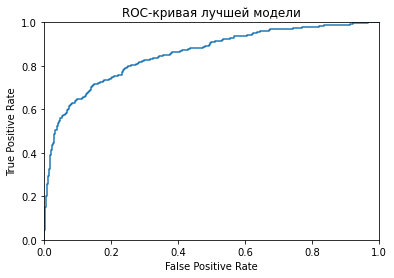

In [35]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC-кривая лучшей модели")

plt.show()

## Вывод

**В проекте были рассмотрены данные - 10000 строк о клиентах банка и расторжениях договоров с этим банком. Задачей было предсказать, уйдет клиент в ближайшее время или нет. Для этого данные были подготовлены (пропуски удалены, нечисловые признаки закодированы, все признаки отмасштабированы), разделены на 3 выборки - обучающую, валидационную и тестовую, и на этих выборках были протестированы 2 модели - случайный лес и логистическая регрессия. Критерием оценки эффективности модели была f1-мера. Значение метрики оказалось недостаточным (порог в задании 0.59), поэтому был обработан дисбаланс классов, после чего модель случайного леса достигла значения f1-меры в 0.618. Дополнительно у моделей измерялась AUC-ROC, ее значение для выбранной модели на тестовой выборке 0.855.** 